In [1]:
import bluesquare_data_pipelines.access as blsq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
hivdr_de = pd.read_csv("../data/processed/hivdr_de_mapping.csv", sep=';')
iap_covariates = pd.read_csv("../data/processed/iap_covariates.csv")
iap_matched = pd.read_csv("../data/processed/iap_fosa_matched.csv")
iap_matched = iap_matched.dropna()

/anaconda3/envs/bsqvenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
labelled_covariates = iap_covariates.merge(hivdr_de)
full_data = labelled_covariates.merge(iap_matched, left_on = "uidorgunit", right_on = "fosa_id")
full_data = full_data[['monthly', 'quarterly', 'dataelementname', 'catcomboname','population', 
                       'action', 'sub_population', 'province', 'fosa','value']]

In [4]:
def make_sum(data):
    if data.value.iloc[0] in ["true", "false"]:
        out = pd.DataFrame.from_dict({"value":[data.value.iloc[0]]})
    else :
        data.value = data.value.astype(float)
        out = pd.DataFrame.from_dict({"value":[data.value.sum()]})
    return out

full_data = full_data.groupby(["province","fosa","monthly","quarterly", "population","action","sub_population","dataelementname"]).apply(make_sum)

In [5]:
full_data = full_data.reset_index().drop("level_8", 1)
full_data["standard_de"] = full_data["population"] + "_" + full_data["action"]  + "_" + full_data["sub_population"]

In [6]:
useful_variables = full_data[~(full_data.population == "vih_positive") &  
                             ~(full_data.action.str.contains("tb|cv|_ist|dead|cotrim|nut|treatment_supplement|no_treatment_response|counciled_tested")) &
                             ~(full_data.sub_population.str.contains("soutien"))]

In [7]:
len(useful_variables)

18196

In [18]:
len(useful_variables.fosa.unique().tolist())

76

In [8]:
treat_scheme = ["azt_3tc_lpv_r","tdf_ftc_nvp","abc_3tc_nvp","abc_3tc_efv","azt_3tc_efv","tdf_3tc_efv",
                "tdf_3tc_nvp","tdf_3tc_lpv_r","tdf_ftc_efv","azt_3tc_nvp","abc_3tc_lpv_r","tdf_ftc_lpv_r"]

treatments = useful_variables[useful_variables.sub_population.isin(treat_scheme)]
treatments_fu = treatments.groupby(["province","fosa","monthly","sub_population"]).value.sum().reset_index()
treatments_fu["line"] = 'first_line'
treatments_fu.loc[treatments_fu.sub_population.str.contains("lpv"),"line"] = "second_line"
line_fu = treatments_fu.groupby(["province","fosa","line"]).value.mean().reset_index()
line_fu = line_fu.set_index(["province","fosa"]).pivot(columns = "line")["value"].reset_index()

In [9]:
len(line_fu)

76

In [10]:
pdv_data = useful_variables[(useful_variables.action == "pdv")]
pdv_data.value = pd.to_numeric(pdv_data.value)
pdv_data = pdv_data.groupby(["province","fosa"]).value.mean().reset_index()
pdv_data.columns = ["province", "fosa", "n_pdv"]

/anaconda3/envs/bsqvenv/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [11]:
print(pdv_data) # "losing" 13 fosas

          province               fosa       n_pdv
0     haut katanga     camp kamalondo    0.000000
1     haut katanga       hgr kapolowe    0.031250
2     haut katanga         hgr katuba    0.000000
3     haut katanga        hgr kisanga    0.000000
4            ituri        ch rwankole    1.000000
5            ituri          hgr bunia    3.153846
6            ituri           hgr nizi    5.444444
7    kasai central      hgr mikalayi     3.800000
8    kasai central       hgr tshikaji    0.266667
9   kasai oriental        hgr dibindi    2.333333
10  kasai oriental        hgr bonzola    0.285714
11  kasai oriental        hgr dipumba   16.000000
12  kasai oriental       hgr kansele     3.692308
13        kinshasa          ch kikimi    1.363636
14        kinshasa           cs bomoi    6.000000
15        kinshasa          cs bomoto  117.943396
16        kinshasa          cs esengo   27.000000
17        kinshasa       hgr kintambo    4.583333
18        kinshasa         hgr kokolo    0.222222


In [12]:
pvvih_data = useful_variables[(useful_variables.population == "pvvih") & (useful_variables.action == "enrolled_hiv_services")]
pvvih_data.value = pd.to_numeric(pvvih_data.value)
pvvih_data = pvvih_data.groupby(["province","fosa"]).value.mean().reset_index()
pvvih_data.columns = ["province", "fosa", "n_pvvih"]

In [13]:
len(pvvih_data) # losing 10 fosas

66

In [14]:
stock_out_data = useful_variables[useful_variables.action == "rupture_stock_mois"]
def stock_out_prob(data):    
    return sum(data == "true") / len(data)


stock_out_data = stock_out_data.groupby(["province","fosa"]).value.apply(stock_out_prob).reset_index()
stock_out_data.columns = ["province", "fosa", "stockout_perc"]

In [19]:
len(stock_out_data)

76

In [15]:
cmm_data = useful_variables[useful_variables.action == "cmm_mois"]

cmm_data = cmm_data.groupby(["province","fosa","monthly"]).value.sum().reset_index().groupby(["province","fosa"]).value.sum().reset_index()
cmm_data.columns = ["province", "fosa", "cmm"]

In [20]:
len(cmm_data)

76

In [34]:
covariables = cmm_data.merge(stock_out_data).merge(line_fu).merge(pdv_data)#.merge(pvvih_data)#.merge(pdv_data)#.merge(line_fu
print(len(covariables))

63


In [35]:
#covariables.head(n=20)

,province,fosa,cmm,stockout_perc,first_line,second_line,n_pdv,n_pvvih
0,haut katanga,camp kamalondo,1.000000,0.000000,7.916667,0.250000,0.000000,48.026316
1,haut katanga,hgr kapolowe,784.197368,0.037037,18.250000,0.000000,0.031250,157.250000
2,haut katanga,hgr katuba,4.500000,0.000000,42.000000,1.333333,0.000000,626.523810
3,haut katanga,hgr kisanga,24.750000,0.000000,15.750000,0.000000,0.000000,98.875000
4,ituri,ch rwankole,403.366667,0.000000,14.041667,0.000000,1.000000,113.187500
5,ituri,hgr bunia,1231.666667,0.518519,141.666667,0.250000,3.153846,788.259259
6,ituri,hgr nizi,240.000000,0.037037,8.583333,0.166667,5.444444,232.250000
7,kasai central,hgr mikalayi,600.000000,0.000000,10.750000,0.000000,3.800000,73.526316
8,kasai central,hgr tshikaji,6900.000000,0.000000,4.416667,0.000000,0.266667,44.722222
9,kasai oriental,hgr dibindi,17233.833333,0.000000,73.000000,7.416667,2.333333,479.521739


In [68]:
covariables_tot = cmm_data.merge(stock_out_data, how = 'outer').merge(line_fu, how = 'outer').merge(pdv_data, how = 'outer').merge(pvvih_data, how = 'outer').merge(pdv_data, how = 'outer').merge(line_fu, how = 'outer')
#covariables_tot.head(n=20)
covariables_tot['adminid'] = covariables_tot.province.astype(str).str[-4:]
covariables_tot = covariables_tot.reset_index()

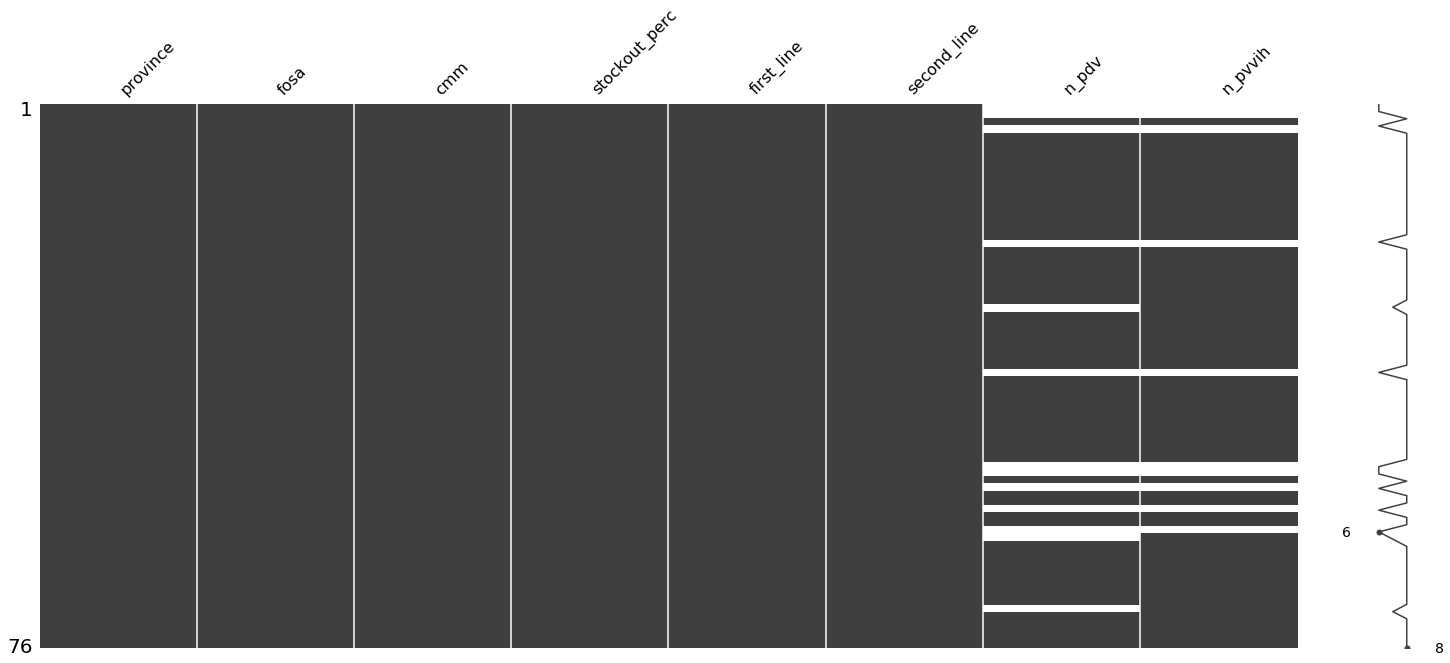

In [42]:
import missingno as msno
%matplotlib inline
msno.matrix(covariables_tot)

In [ ]:
msno.geoplot(covariables_tot, x='LONGITUDE', y='LATITUDE', by='ZIP CODE')

In [49]:
import os
os.getcwd()



'/Users/allorant/bluesquare/repo/hivdr/notebooks'

In [69]:
import geopandas as gpd
shapefile = gpd.read_file("../data/ZAI.shp")
shapefile['adminid'] = shapefile.loc[:,'ADM1'].str.lower().astype(str).str[-4:]
shapefile = shapefile.reset_index()

In [84]:
shape_data = shapefile.merge(covariables_tot, on = 'adminid', how = "outer")
shape_data['NumberMissing']=shape_data.isnull().sum(axis=1)

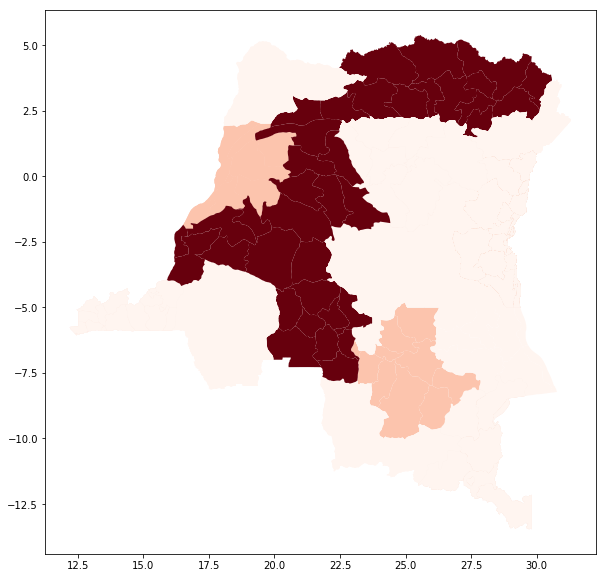

In [94]:
import descartes
shape_data.plot(figsize=(10,10), column = 'NumberMissing', cmap = 'Reds')

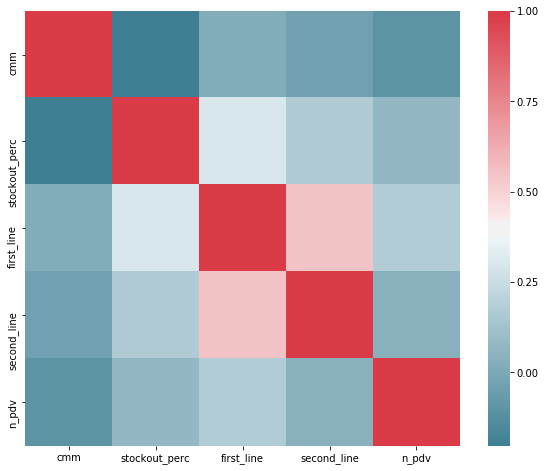

In [21]:
f, ax = plt.subplots(figsize=(10, 8))
corr = covariables.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Text(0.5, 0.98, 'Distribution of the predictors for EWIs')

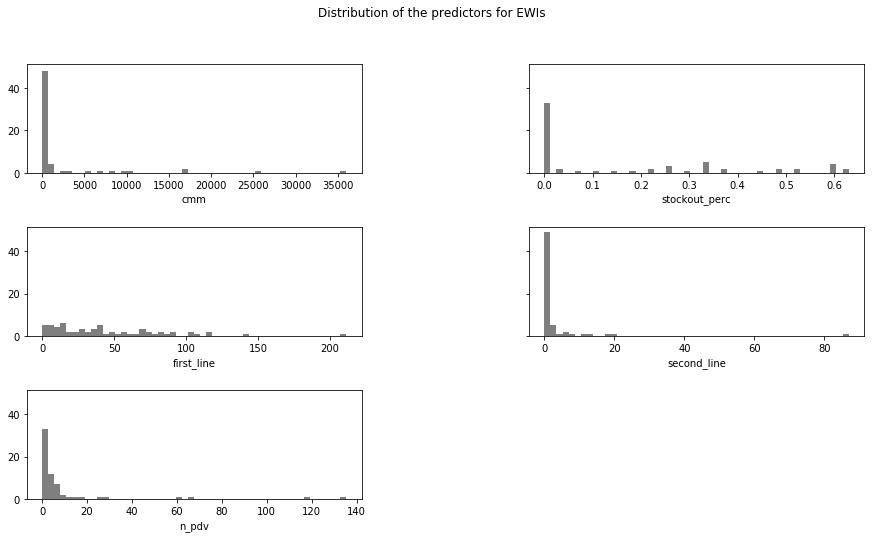

In [29]:
fig,axes = plt.subplots(3,2,sharex=False,sharey=True, figsize=(15, 8))
axes[-1, -1].axis('off')

axes[0,0].hist(covariables[covariables.columns[2]],bins=50,color='k',alpha=0.5)
axes[0,0].set_xlabel(covariables.columns[2])

axes[0,1].hist(covariables[covariables.columns[3]],bins=50,color='k',alpha=0.5)
axes[0,1].set_xlabel(covariables.columns[3])

axes[1,0].hist(covariables[covariables.columns[4]],bins=50,color='k',alpha=0.5)
axes[1,0].set_xlabel(covariables.columns[4])

axes[1,1].hist(covariables[covariables.columns[5]],bins=50,color='k',alpha=0.5)
axes[1,1].set_xlabel(covariables.columns[5])

axes[2,0].hist(covariables[covariables.columns[6]],bins=50,color='k',alpha=0.5)
axes[2,0].set_xlabel(covariables.columns[6])

plt.subplots_adjust(wspace=.5,hspace=.5)
plt.suptitle('Distribution of the predictors for EWIs')